# Introducing word embeddings

> ⚠️ The cells of this notebook have been executed to facilitate the use of [readthedocs.io](applied-language-technology.readthedocs.io/). If you wish to work through the notebook step-by-step, go to the *Kernel* menu and select *Restart & Clear Output*.

Word embeddings are a technique for learning numerical representations for individual words based on the context in which the words appear. 

Such numerical representations are a prerequisite for computational processing, that is, performing calculations, statistical analyses and making predictions.

After reading this section, you should:

 - understand the relation between word embeddings and the underlying distributional hypothesis
 - how different aspects of linguistic structure can be represented numerically
 - understand how word embeddings are learned

## Background: linguistic perspectives on word embeddings

The inspiration for word embeddings is often attributed to the following observation by the English linguist [J.R. Firth](https://en.wikipedia.org/wiki/John_Rupert_Firth):

> "You shall know a word by the company it keeps."

What Firth means is that the meaning of a word can be inferred by examining that word in its context of occurrence.

Martin ([2016](https://doi.org/10.1080/00437956.2016.1141939): 45) notes that Firth's interest in the co-occurrences of words, or *collocations*, spawned a wealth of linguistic research, particularly in the field of corpus linguistics. 

Firth's observation also resonates with the so-called *distributional hypothesis* proposed by Harris ([1954](https://doi.org/10.1080/00437956.1954.11659520)), which posits that linguistic items with similar distributions should have similar meanings.

Examining the distributional hypothesis from a linguistic perspective, Magnus Sahlgren ([2008](http://soda.swedish-ict.se/3941/1/sahlgren.distr-hypo.pdf): 33–34) points out that:

> "Proponents of distributional methods often seem comfortable to ascribe meaning to distributional representations without explaining what they _mean_ by meaning. For the non-distributionalist, on the other hand, this will surely seem odd if not completely outrageous, since meaning is usually taken to involve both reference to objects and situations in the world outside language, and to concepts and ideas inside the mind of the language user."

Sahlgren ([2008](http://soda.swedish-ict.se/3941/1/sahlgren.distr-hypo.pdf): 34) argues that the distributional hypothesis has roots in "structuralist soil", that is, [Ferdinand de Saussure](https://en.wikipedia.org/wiki/Ferdinand_de_Saussure)'s ideas about the structure of language.

Saussure described language from two perspectives: *langue*, the abstract system constituted by language, and *parole*, particular instances of language produced by the underlying system of *langue*. 

Saussure characterised *langue* as having *paradigmatic* and *syntagmatic* axes of organisation, which allow making choices between alternatives and combining them into larger units. The available choices emerge through oppositions: alternatives can only be identified by what they are and what they are not.

![](img/parasyn.svg)

Saussure's and Firth's ideas were taken further by [M.A.K. Halliday](https://en.wikipedia.org/wiki/Michael_Halliday), who incorporated them into the foundations of a theory of language known as [systemic functional linguistics](https://en.wikipedia.org/wiki/Systemic_functional_linguistics) (for a recent overview of the field, see Martin [2016](https://doi.org/10.1080/00437956.2016.1141939)). 

In contrast to Saussure's view of language as a static system of oppositions, Halliday emphasises the role of *choice* for language. 

Halliday argues that language is defined by *meaning potential*, which is realised *dynamically* by making choices within intersecting linguistic systems. These systems are provided by *lexicogrammar*, which Halliday describes as a cline: the choices made within language become increasingly delicate when moving from grammar to lexis (see e.g. Fontaine [2017](https://doi.org/10.1186/s40554-017-0051-7)).

Against this backdrop, we will now turn to explore the distributional hypothesis from both syntagmatic and paradigmatic perspectives.

## Exploring the distributional hypothesis

### A syntagmatic perspective

As introduced above, syntagmatic organisations emerge as choices made within language are combined into larger units.

To explore syntagmatic organisations in a corpus of texts, we can build a co-occurrence matrix to examine which words co-occur with each other within some sequence. These sequences may be motivated linguistically, as exemplified by a clause or a sentence, or they may simply consist of words within some distance of one another. 

To do so, we must retrieve unique words and count their occurrences across all sequences.

Let's start by importing the *spaCy* library and a medium-sized language model for English.

In [1]:
# Import the spaCy library
import spacy

# Load a medium-sized language model for English; assign to variable 'nlp'
nlp = spacy.load('en_core_web_md')

We then define a toy example consisting of example sentences in a list, which we assign to the variable `sents`.

In [2]:
# Create list
sents = ["Helsinki is the capital of Finland",
         "Tallinn is the capital of Estonia",
         "The two capitals are joined by a ferry connection",
         "Travelling between Helsinki and Tallinn takes about two hours",
         "Ferries depart from downtown Helsinki and Tallinn"]

# Print list contents
print(sents)

['Helsinki is the capital of Finland', 'Tallinn is the capital of Estonia', 'The two capitals are joined by a ferry connection', 'Travelling between Helsinki and Tallinn takes about two hours', 'Ferries depart from downtown Helsinki and Tallinn']


We can then feed this list to the English language model under `nlp` and store the resulting _Doc_ object under the variable `docs`.

To process the example sentences effectively, we can use the `pipe()` method, which takes a list as an input.

The `pipe()` method returns a generator object, which we have to cast into a list.

In [3]:
# Feed the list of example sentences 'sents' to the pipe() method.
# Cast the result into a list and store under the variable 'docs'.
docs = list(nlp.pipe(sents))

# Call the variable to check the output
docs

[Helsinki is the capital of Finland,
 Tallinn is the capital of Estonia,
 The two capitals are joined by a ferry connection,
 Travelling between Helsinki and Tallinn takes about two hours,
 Ferries depart from downtown Helsinki and Tallinn]

For purposes of convenience and simplicity, we examine the co-occurrence of lemmas rather than the inflected forms of words. 

To count the lemmas in each sentence, we must import the `LEMMA` object from spaCy's `attrs` module. 

`LEMMA` is just an object that refers to this particular linguistic feature, which we can pass to the `count_by()` method of a *Doc* object to instruct *spaCy* to count these linguistic features.

In [4]:
# Import the LEMMA object from the 'attrs' module of spaCy
from spacy.attrs import LEMMA

We then define a Python *dictionary comprehension* to count the lemmas in each sentence.

A dictionary comprehension is declared using curly braces `{ }`, which are also used to designate a dictionary in Python.

Because Python dictionaries consist of *keys* and *values*, we need **two** items to populate the new `lemma_counts` dictionary using a dictionary comprehension:

 1. `i` refers to the number returned by the `enumerate` function that keeps count of items
 2. `doc` refers to the current document in `docs`, our _list_ of _Doc_ objects
 
Note that on the right-hand side of the `for` statement, these two variables are separated by a comma.
 
The left-hand side of the `for` statement defines what is actually stored in the `lemma_counts` dictionary. 

In this case, we store the count `i` as the *key* and assign the output of the `count_by` method as the *value*.

On the left-hand side, these variables are separated by a colon.

In [5]:
# Use a dictionary comprehension to populate the 'lemma_counts' dictionary
lemma_counts = {i: doc.count_by(LEMMA) for i, doc in enumerate(docs)}

# Call the variable to check the output
lemma_counts

{0: {332692160570289739: 1,
  10382539506755952630: 1,
  7425985699627899538: 1,
  15481038060779608540: 1,
  886050111519832510: 1,
  4881666681900411319: 1},
 1: {7392857733388117912: 1,
  10382539506755952630: 1,
  7425985699627899538: 1,
  15481038060779608540: 1,
  886050111519832510: 1,
  15428882767191480669: 1},
 2: {7425985699627899538: 1,
  11711838292424000352: 1,
  15481038060779608540: 1,
  10382539506755952630: 1,
  16238441731120403936: 1,
  16764210730586636600: 1,
  11901859001352538922: 1,
  16008623592554433546: 1,
  14753437861310164020: 1},
 3: {9016120516514741834: 1,
  7508752285157982505: 1,
  332692160570289739: 1,
  2283656566040971221: 1,
  7392857733388117912: 1,
  6789454535283781228: 1,
  942632335873952620: 1,
  11711838292424000352: 1,
  9748623380567160636: 1},
 4: {16008623592554433546: 1,
  11568774473013387390: 1,
  7831658034963690409: 1,
  18137549281339502438: 1,
  332692160570289739: 1,
  2283656566040971221: 1,
  7392857733388117912: 1}}

As you can see, the `lemma_counts` dictionary contains the _Doc_ numbers as *keys* and dictionaries as *values*!

At a glance, these dictionaries obviously report some counts, but as we learned in [Part II](../part_ii/03_basic_nlp.ipynb), *spaCy* uses hash values for *Tokens* for efficiency, which explains the presence of weird sequences of numbers.

We can map the hash values to actual words by performing a slightly more complicated dictionary comprehension.

Below we update the `lemma_counts` dictionary in two steps:

 1. Looping over *key* (`i`) and *value* (`counter`) pairs, which are accessible through the `items()` method of the `lemma_counts` dictionary.
 
 This is done by the part on the **right** hand side of the `for` statement, e.g. `i, counter in lemma_counts.items()`.
 
 
 2. Updating the *keys* and *values* of the `lemma_counts` dictionary by preserving the original key `i` that defines the sentence number.
 
 Because the dictionary *value* stored under `counter` is another dictionary, we must define yet another dictionary comprehension!
 
 This dictionary comprehension is just like the one above, but this time we update the *keys* of the `counter` dictionary to replace the hash values with text.
 
 To do so, we access the sentence in question from the list of spaCy *Doc* objects `docs` by referring to the sentence number under `i`. We then provide the hash value under `k` to the `vocab` attribute to fetch the contents of the attribute `text`.
 
This illustrates just how much a single line of Python can achieve using powerful expressions such as dictionary comprehensions.

In [6]:
# Use a dictionary comprehension to replace the keys of the 'lemma_counts' dictionary
lemma_counts = {i: {docs[i].vocab[k].text: v for k, v in counter.items()} for i, counter in lemma_counts.items()}

# Call the variable to check the output
lemma_counts

{0: {'Helsinki': 1, 'be': 1, 'the': 1, 'capital': 1, 'of': 1, 'Finland': 1},
 1: {'Tallinn': 1, 'be': 1, 'the': 1, 'capital': 1, 'of': 1, 'Estonia': 1},
 2: {'the': 1,
  'two': 1,
  'capital': 1,
  'be': 1,
  'join': 1,
  'by': 1,
  'a': 1,
  'ferry': 1,
  'connection': 1},
 3: {'travel': 1,
  'between': 1,
  'Helsinki': 1,
  'and': 1,
  'Tallinn': 1,
  'take': 1,
  'about': 1,
  'two': 1,
  'hour': 1},
 4: {'ferry': 1,
  'depart': 1,
  'from': 1,
  'downtown': 1,
  'Helsinki': 1,
  'and': 1,
  'Tallinn': 1}}

This gives us a dictionary with *Doc* numbers as *keys* and dictionaries with lemma counts as *values*.

To better understand these counts, we can organise them into a tabular form using a *pandas* DataFrame.

This table provides a co-occurrence matrix of lemmas and sentences.

We can easily populate the DataFrame by feeding the dictionary of *Docs* and lemma count dictionaries to the `from_dict()` method.

In [7]:
# Import the pandas library
import pandas as pd

# We then create a pandas DataFrame using the .from_dict() method,
# to which we pass the dictionary under 'lemma_counts'. We then
# sort the index in an ascending order using the sort_index() method.
df = pd.DataFrame.from_dict(lemma_counts).sort_index(ascending=True)

# Replace NaN values with zeroes using the fillna() method.
# Finally, we use .T attribute to transpose the DataFrame.
# This switches the place of columns and rows to improve legibility.
df = df.fillna(0).T

# Print out the DataFrame
df

,Estonia,Finland,Helsinki,Tallinn,a,about,and,be,between,by,...,downtown,ferry,from,hour,join,of,take,the,travel,two
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This returns a DataFrame with *unique lemmas* across all sentences in the columns, while the individual *Docs* occupy rows at indices 0–4.

Each cell in the DataFrame counts how many times a given lemma occurs in a *Doc*.

We can use these counts to examine the co-occurrence of lemmas within each *Doc*.

Let's examine the values for the first sentence by using the `iloc` accessor, which allows accessing the indices in a *pandas* DataFrame.

We access the first *Doc* at index `0` and retrieve the values using the `values` attribute.

In [8]:
df.iloc[0].values

array([0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0.])

This returns an *array*, or a list of values that counts the occurrence of lemmas in the *Doc*.

In mathematics, such lists of numbers are called *vectors*.

The length of this vector is defined by the number of *unique* lemmas across *all* *Docs*.

This number defines the *dimensionality* of the vector.

Because each sentence is now represented by a numerical vector, we can easily perform mathematical operations, such as calculate the distance between each pair of vectors to evaluate their similarity.

To do so, we can import the `cosine_similarity()` function from the *scikit-learn* library, which allows measuring [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) between vectors.

In [9]:
# Import the function for measuring cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

# Evaluate cosine similarity between vectors
sim = cosine_similarity(df.values)

# Call the variable to examine the output
sim

array([[1.        , 0.66666667, 0.40824829, 0.13608276, 0.15430335],
       [0.66666667, 1.        , 0.40824829, 0.13608276, 0.15430335],
       [0.40824829, 0.40824829, 1.        , 0.11111111, 0.12598816],
       [0.13608276, 0.13608276, 0.11111111, 1.        , 0.37796447],
       [0.15430335, 0.15430335, 0.12598816, 0.37796447, 1.        ]])

This returns a 5 by 5 matrix with measures for cosine similarity between each pair of sentences.

To help us interpret this table, let's import the `heatmap()` function from the _seaborn_ library to visualise the cosine similarity matrix.

<AxesSubplot:>

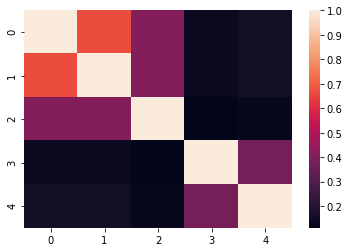

In [10]:
# Import the heatmap function from the seaborn library
from seaborn import heatmap

# Provide the cosine similarity matrix under 'sim' to the heatmap() function
heatmap(sim)

Each row and column in the heatmap represent a single *Doc*.

The heatmap shows a diagonal line across the table with values of 1.0, because each *Doc* is also compared to itself!

These *Docs* are naturally perfectly similar, which results in a value of 1.0.

What we can also see is that *Docs* 0 and 1 feature some similarities, while most *Docs* are not similar at all, as their values are 0.0.

To summarise, a co-occurrence matrix can describe *syntagmatic structures* by paradigmatic choices that co-occur within some fixed unit or window of a given length (in our case, a sentence).

The downside to this approach, however, is that when the size of the vocabulary in the corpus increases, so does the size of the co-occurrence matrix. For each new word, we must add another dimension for keeping track of its occurrences.

Furthermore, the co-occurrence matrix does not contain information about the *order* in which the words appear. For this reason, such representations are often characterised using the term "[bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model)".

The lack of information about word sequences complicates the identification of paradigmatic alternatives, that is, words that *could* have occurred in connection with other words.

### A paradigmatic perspective

To explore the distributional hypothesis from a paradigmatic perspective, we must shift the target of description from sequences of text to words.

Just as we represented entire sentences using vectors with the help of a co-occurrence matrix, we can do the same for individual words.

Let's start by taking the unique lemmas in our corpus of *Docs*.

These can be easily retrieved from the DataFrame `df` by accessing the `columns` attribute, because the columns correspond to the unique lemmas. We then use the `tolist()` method to convert the output into a Python list.

In [11]:
# Retrieve the unique lemmas from the DataFrame and convert to list
unique_lemmas = df.columns.tolist()

# Call the variable to examine the output
unique_lemmas

['Estonia',
 'Finland',
 'Helsinki',
 'Tallinn',
 'a',
 'about',
 'and',
 'be',
 'between',
 'by',
 'capital',
 'connection',
 'depart',
 'downtown',
 'ferry',
 'from',
 'hour',
 'join',
 'of',
 'take',
 'the',
 'travel',
 'two']

We can use a technique called *one-hot encoding* to represent each lemma numerically.

One-hot encoding maps each lemma to a vector, which consists of zeroes except at one one dimension, where the value is one. This encodes the identity of a given word.

Let's examine this in practice by mapping each lemma to a corresponding one-hot vector.

To do so, we import *NumPy*, a Python library for working with arrays (Harris et al. [2020](https://doi.org/10.1038/s41586-020-2649-2)).

In [12]:
# Import NumPy, assign name 'np'
import numpy as np

# Define an empty placeholder dictionary for lemmas and their vectors
lemma_vectors = {}

# Loop over the list of unique lemmas; count items using enumerate()
for i, lemma in enumerate(unique_lemmas):
    
    # Create a vector with a length that corresponds to that of the
    # 'unique_lemmas' list. This matches the size of our vocabulary.
    # The np.zeros() function fills this vector with zeroes.
    vector = np.zeros(shape=len(unique_lemmas))
    
    # Use the brackets to access the vector at the current index 'i',
    # which we retrieve during the loop over the list 'unique_lemmas'.
    # Set the value to one instead of zero at this position in the vector.
    vector[i] = 1
    
    # Store the lemma and vector into the dictionary
    lemma_vectors[lemma] = vector
    
    # Print out the vector and the lemma it corresponds to
    print(vector, lemma)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] Estonia
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] Finland
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] Helsinki
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] Tallinn
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] a
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] about
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] and
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] be
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] between
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] by
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] capital
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] connection
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

As you can see, dimensions that have a value of 1.0 form a diagonal line across the vectors.

This diagonal line emerges because each dimension of the vector encodes the presence of a unique lemma. 

We can use these vectors to encode sequences of words into numerical representations, which allows us to capture paradigmatic choices in their syntagmatic context of occurrence!

Put differently, we can now observe which words occur in similar contexts and are potentially *paradigmatic alternatives*.

In [13]:
# Loop over Tokens in the first Doc in the list
for token in docs[0]:
    
    # Get the lemma of each token under the attribute 'lemma_'
    # and use this as a key for the 'lemma_vectors' dictionary
    # to retrieve the associated vector. Then print the lemma
    # itself.
    print(lemma_vectors[token.lemma_], token.lemma_)

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] Helsinki
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] be
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] the
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] capital
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] of
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] Finland


We can join these vector representations of individual words into a *matrix*, a multidimensional "table" of vectors.

We can use NumPy's `vstack()` method to stack the vectors vertically, that is, place the vectors on top of each other to form a matrix that represents the entire *Doc*.

In [14]:
# Use a list comprehension to collect the vectors for each lemma in the first Doc
sentence_matrix = np.vstack([lemma_vectors[token.lemma_] for token in docs[0]])

# Call the variable to examine the output
sentence_matrix

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]])

We can examine the shape of the resulting matrix using the attribute `shape`.

In [15]:
sentence_matrix.shape

(6, 23)

The `shape` attribute contains the shape of the matrix: six rows, one for each lemma, and 23 columns, which encode the presence of individual lemmas in the vocabulary.

A matrix allows representing any sequence of *Tokens* numerically. However, as the size of the vocabulary grows, so does the number of dimensions needed to represent each unique word in the vocabulary.

These vectors are often characterised as *sparse*, because most dimensions do not encode any information, but consist of zero values.

To make word embeddings efficient, each dimension of a vector should encode some information about the word and the context in which it occurs.

This can be achieved by learning word embeddings directly from data.

## Learning word embeddings

As introduced above, we can now map each lemma to a sparse vector, which consists of zeros except in one position (or dimension), which encodes the identity of a given lemma by having a value of 1.

We can use the mappings between a word and its vector to encode any sequence of words, provided that the words are included in our vocabulary.

Because we can now represent any word numerically as a vector, we can use these vectors to train an algorithm to predict which words are likely to occur close to each other.

To do so, we must determine what we consider as a neighbour to a given word.

To exemplify, let's choose the second *Doc* in the list `docs` as an example.

In [16]:
# Access the second Doc in the list: remember zero-indexing!
docs[1]

Tallinn is the capital of Estonia

Let's assume that the two neighbouring words on either side of a word count as its neighbours.

To examine a single word, let's access the third _Token_ in the second *Doc*.

In [17]:
# Access the second Doc and the third Token
docs[1][2]

the

We can use the `nbor()` method of a *Token* to fetch the neighbours of the current *Token*.

The `nbor()` method takes an integer as input, which determines the position relative to the current *Token*. 

Negative integers refer to the indices of *Tokens* that come before the current *Token*, while positive integers refer to those that come after.

In [18]:
# Get the preceding Token at position -1
docs[1][2].nbor(-1)

is

In [19]:
# Get the follow Token at position +1
docs[1][2].nbor(1)

capital

In order to train an algorithm to predict neighbouring words, we must first collect all words that occur within a two-word window of a given word.

In linguistics, words that co-occur with each other are known as a collocation.

Note that our approach only approximates collocations, since our definition of a word's neighbourhood is not motivated linguistically, whereas actual collocates often are. In other words, our search for collocates can easily violate the borders of perceived linguistic structures.

Furthermore, not all words have neighbours on both sides: the words that start or finish a sentence or some other sequence will not have preceding or following words.

To deal with this problem, we can use the `try` and `except` statements in Python to catch the errors arising from missing neighbours.

In [20]:
# Define a list to hold Tokens and their neighbouring Tokens
pairs = []

# Loop over each Doc in the list of Docs under the variable 'docs'
for doc in docs:
    
    # Loop over each Token in a Doc
    for token in doc:
        
        # Loop over the indices of neighbouring Tokens that are of 
        # interest to us.
        for neighbour_i in [-2, -1, 1, 2]:
        
            # Try to retrieve neighbour at position 'neighbour_i'
            try:

                # Assign the preceding Token into the variable 'context'
                context = token.nbor(neighbour_i)
            
                # Append a tuple consisting of the current Token
                # and the neighbouring Token to the list 'pairs'
                pairs.append((token.lemma_, context.lemma_))
        
            # Use the except command to catch the error arising if 
            # there is no preceding Token ('IndexError')
            except IndexError:

                # Move to the next Token in the list of neighbours
                continue

This produces a list of tuples that contain word pairs that occur within two words of each other.

Let's print out the first 10 pairs to examine the result.

In [21]:
# Print out the first 10 tuples in the list 'pairs'
pairs[:10]

[('Helsinki', 'be'),
 ('Helsinki', 'the'),
 ('be', 'Helsinki'),
 ('be', 'the'),
 ('be', 'capital'),
 ('the', 'Helsinki'),
 ('the', 'be'),
 ('the', 'capital'),
 ('the', 'of'),
 ('capital', 'be')]

The first word in each tuple can be described as the *target* lemma, whereas the second constitutes a *context* lemma.

To set the stage for making predictions, we must collect all target words in the list and their matching context words, while also converting them into their one-hot encoded numerical representations. 

This can be achieved by a list comprehension, which loops over the tuples in the list `pairs`. We can then fetch the one-hot encoded vector from the dictionary `lemma_vectors` by using the target lemma as the key.

In [22]:
# Define a list comprehension that collects target lemmas and stores
# the one-hot encoded vectors into a list named 'targets'
targets = [lemma_vectors[target] for target, context in pairs]

# Stack all the target lemmas into a matrix
targets = np.vstack(targets)

# Call the variable to check the size of the matrix
targets.shape

(118, 23)

Examining the `shape` attribute reveals that we have a total of 118 target lemmas. We then repeat the same operation for their matching context lemmas.

In [23]:
# Define a list comprehension that collects context lemmas and stores
# the one-hot encoded vectors into a list named 'context'
context = [lemma_vectors[context] for target, context in pairs]

# Stack all the context lemmas into a matrix
context = np.vstack(context)

# Call the variable to check the size of the matrix
context.shape

(118, 23)

Perfect! Each target lemma in `targets` now has a matching context lemma under `context`. 

Next, we will define a small neural network, which attempts to learn a mapping between the target and context lemmas.

In other words, given a target word, the network attempts to predict which context lemmas are likely to occur near the target lemma. 

To do so, we define a small neural network using [Keras](https://keras.io/).

More specifically, we implement a variant of an algorithm called *Word2vec* (for *word to vector*), proposed by Tomas Mikolov et al. ([2013](https://arxiv.org/abs/1301.3781v3)).

Keras is a part of the TensorFlow deep learning library; we import both Keras and *Dense*, a specific type of neural network layer.

In [24]:
from tensorflow import keras
from tensorflow.keras.layers import Dense

We start by defining an *Input* layer, which receives the one-hot encoded vectors stored under the variable `targets`.

We fetch the size of the second dimension (`[1]`) of the `targets` matrix available under the `shape` attribute. We then provide this information to the `shape` *argument* of the *Input* layer, which informs the neural network about the size of the incoming data.

We also use the `name` argument to name the layer as `input_layer`. 

We store the resulting *Input* object under the variable `network_input`.

In [25]:
network_input = keras.Input(shape=targets.shape[1], name='input_layer')

Next, we define a *Dense* layer with two neurons, as defined by the `units` argument. 

We connect the *Input* layer to this layer by placing the variable `network_input` in parentheses after the *Dense* layer, e.g. `Dense(...)(network_input)`. 

We assign the output of the *Dense* layer under variable `hidden_layer`.

In [26]:
hidden_layer = Dense(units=2, activation=None, name='hidden_layer')(network_input)

To make predictions about which context lemmas occur close to the target lemmas, we then define another *Dense* layer whose `units` argument matches the size of our vocabulary.

This layer acts as the output layer of our network.

By setting the `activation` argument to `softmax`, the network will return probabilities for all lemmas in the vocabulary.

In [27]:
output_layer = Dense(units=context.shape[1], activation='softmax', name='output_layer')(hidden_layer)

We then combine the layers defined above into a network and assign the result under the variable `embedding_model`.

This is achieved using the *Model* object in Keras and its two arguments: `inputs` and `outputs`, to which we must provide the input and output layers of our network, that is, `input_layer` and `output_layer`.

In [28]:
embedding_model = keras.Model(inputs=network_input, outputs=output_layer)

Finally, we use the `compile()` method to compile the model and define a loss function using the `loss` argument. 

The purpose of a loss function is to measure the error between predicted and actual context lemmas. This error is used to adjust the neurons in a way that should potentially improve the predictions next time.

In [29]:
embedding_model.compile(loss='categorical_crossentropy')

To examine the resulting model, we call the `summary()` method.

In [30]:
embedding_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 23)]              0         
_________________________________________________________________
hidden_layer (Dense)         (None, 2)                 48        
_________________________________________________________________
output_layer (Dense)         (None, 23)                69        
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________


We have now compiled a simple neural network. The network has a single hidden layer with two neurons, which acts as a bottleneck for information.

To learn how to predict the context lemmas based on the target lemmas, the model must learn to condense information contained in the sparse input vectors.

The next step is to train the model. This is achieved using the model's `fit()` function.

This function requires defining several arguments. The arguments `x` and `y` correspond to the inputs and outputs. These consist of the target and context lemmas, which are stored in the matrices under `targets` and `context`, respectively. 

We examine 64 pairs of target and context lemmas at the same time, as defined by the keyword `batch`, and loop over all pairs of lemmas 1500 times, as defined by the keyword `epochs`.

We also provide the `verbose` argument with a value of 0 to avoid flooding the notebook with status messages about the training procedure.

In [31]:
# Fit a model to the data
embedding_model.fit(x=targets,
                    y=context,
                    batch_size=64,
                    epochs=1500,
                    verbose=0
                   )

Now that the neural network has been trained, we can use the model to predict which context lemmas are likely to occur close to the target lemma.

Let's examine these predictions by retrieving the one-hot encoded vector for the lemma "be" and input this to the model.

To do so, we must use the `expand_dims()` function from NumPy to add a dummy axis in front of the network, because our network expects to receive vectors in batches. This tells the network that the input consists of a single vector.

We store the input under the variable `input_array`.

In [32]:
# Add a dummy axis to the input vector
input_array = np.expand_dims(lemma_vectors['be'], axis=0)

# Check the shape of the input array
input_array.shape

(1, 23)

We then input the vector to the model using the `predict()` method, which returns an array of probabilities.

We store these probabilities under the variable `prediction`.

In [33]:
# Feed the input to the neural network; store predictions under 'prediction'
prediction = embedding_model.predict(input_array)

# Call the variable to examine the output
prediction

array([[0.03895581, 0.04121093, 0.04212597, 0.03517739, 0.0285058 ,
        0.01165018, 0.01420426, 0.13894387, 0.00280192, 0.04856807,
        0.17241693, 0.01035706, 0.00747751, 0.00536414, 0.01841469,
        0.01281205, 0.01841119, 0.07494045, 0.06392696, 0.02405063,
        0.13948733, 0.00773188, 0.04246505]], dtype=float32)

These probabilities correspond to the unique lemmas in our vocabulary.

To examine which lemma is the most likely to occur in the neighbourhood of the lemma "be", we can use NumPy's `argmax()` method to find which dimension in the `prediction` vector has the highest value.

This gives us an integer, which we can use as an index for the list of lemmas under `unique_lemmas`.

In [34]:
unique_lemmas[np.argmax(prediction)]

'capital'

However, predicting the most likely neighbour of a given lemma is not the actual *goal* of the training procedure, but this task is more like a proxy for the true objective: to learn numerical representations for individual words. 

To predict context lemmas, the network must learn useful representations for target lemmas. One may think of these numerical representations as the identity of the word, which was previously encoded using a one-hot vector.

These representations are learned by the hidden layer of the neural network, which contains two neurons. 

These neurons have *parameters*, commonly referred to as *weights*, which are adjusted as the network learns to improve predictions based on the error estimated by the loss function.

The weights of a model can be retrieved using the `get_weights()` method of a Keras *Model*.

In [35]:
# Retrieve model weights; assign the resulting list to 'model_weights'
model_weights = embedding_model.get_weights()

# The weights of the hidden layer are the first item in the list
hidden_layer_weights = model_weights[0]

# Call the variable and use the 'shape' attribute to examine size
hidden_layer_weights.shape

(23, 2)

The weights of the hidden layer consist of 23 two-dimensional vectors, one two-dimensional vector for each unique lemma in the vocabulary.

Let's print out the first five vectors to examine their values.

In [36]:
# Check out the first five items in the weight matrix
hidden_layer_weights[:5]

array([[ 2.2699678 ,  1.7514169 ],
       [ 2.6050782 ,  2.012647  ],
       [-0.05873575, -1.18698   ],
       [ 0.6555827 , -1.1613712 ],
       [-1.206744  ,  2.0521815 ]], dtype=float32)

In contrast to the sparse one-hot encoded vectors, the representations learned by the hidden layer may be characterised as *dense*, as each dimension of the vector encodes some information.

We can think of these two-dimensional values as coordinates and plot these dimensions against each other to examine position of each lemma in the two-dimensional space.

This is the *embedding space* for the vectors.

To visualise the embedding space and the vectors within this space, we use a dictionary comprehension to map each unique lemma to its two-dimensional representation in the hidden layer.

In [37]:
# Collect hidden layer weights into a dictionary using a dictionary comprehension
lemma_embeddings = {lemma: hidden_layer_weights[i] for i, lemma in enumerate(unique_lemmas)}

We start by importing the *matplotlib* library and create a figure. The `dpi` argument sets the resolution of the figure to 150 dots per inch.

We then loop over the lemmas and their vector representations in the `lemma_embeddings` dictionary. 

The `items()` method of a dictionary returns both keys and values, which we then add to the *matplotlib* figure.

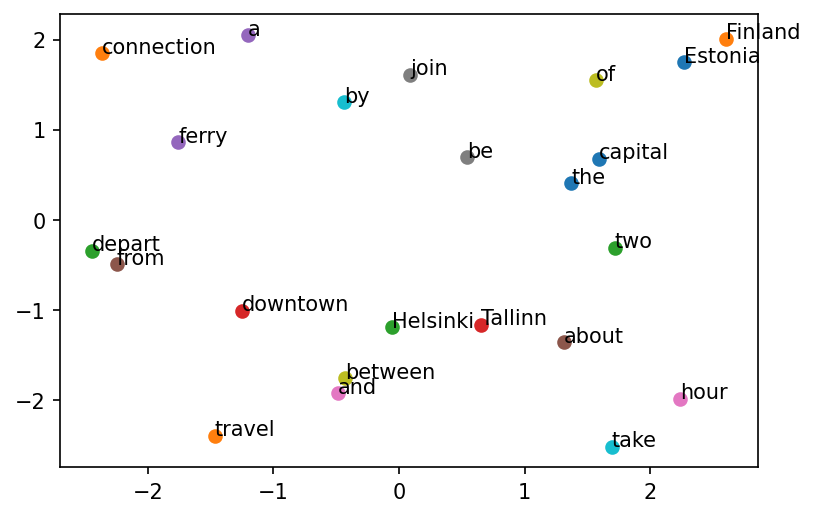

In [38]:
%matplotlib inline

# Import the pyplot component from matplotlib
import matplotlib.pyplot as plt

# Create a figure with a resolution of 200 DPI
plt.figure(dpi=150)

# Loop over the key/value pairs in the dictionary
for lemma, coordinates in lemma_embeddings.items():

    # Unpack the coordinates variable into two variables
    # These stand for the horizontal/vertical coordinates
    x, y = coordinates[0], coordinates[1]
    
    # Use the scatter() method to add the x and y coordinates
    # to the figure
    plt.scatter(x, y)
    
    # Use the annotate() method to add the lemmas as labels 
    # to the coordinate pairs, which must be wrapped into a tuple
    plt.annotate(lemma, (x, y))

Plotting the two dimensions of the vectors against each other provides a visualisation of the vectors in the two-dimensional embedding space.

The vector representations of lemmas that occur in similar contexts should be positioned close to each other in the embedding space.

This section should have given you a basic understanding of the distributional hypothesis, which has been influential in developing the concept of word embeddings.

At the same time, you should have learned that word embeddings are not magic. They are learned directly from the data using a proxy task such as predicting the neighbouring word.

However, one must understand that the toy example presented above merely scratches the surface of language modelling. 

Contemporary approaches use models with complex architectures and billions of parameters, which attempt to encode more information about the neighbouring words, in order to distinguish between homonymic forms such as "bank" as a financial institution and "bank" as an area close to the river.

In the following [section](../part_iii/04_embeddings_continued.ipynb), we dive deeper into word embeddings and how they can be used in spaCy.